In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 设置参数
sc.settings.verbosity = 4
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=300,
    facecolor="white",
    frameon=False,  # remove frame
)

In [4]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.CRITICAL)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


<ipython-input-4-6d3bd39778b0>:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


# 正式分析
- 6.标准化
- 7.去批次
- 8.聚类
- 9.细胞注释
- 10.差异分析

 6.标准化
- 6.1 读取质控后的数据
- 6.2 标准化前检查
- 6.3 基本对数标准化
- 6.4 反卷积标准化：基于池化的尺寸因子估计
- 6.5 正则化负二项式回归：皮尔逊残差标准化
- 6.6 保存
-------------------------------
皮尔逊残差适合发现新细胞,移位对数稳定适合PCA
TODO:对数化等标准化后方差不稳定,参考bioconductor

In [5]:
## 6.1 读取所有质控后的数据
adata = sc.read("anndata_scrublet.h5ad")
## 6.1.1 保存原始counts
adata.raw = adata

/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future versi

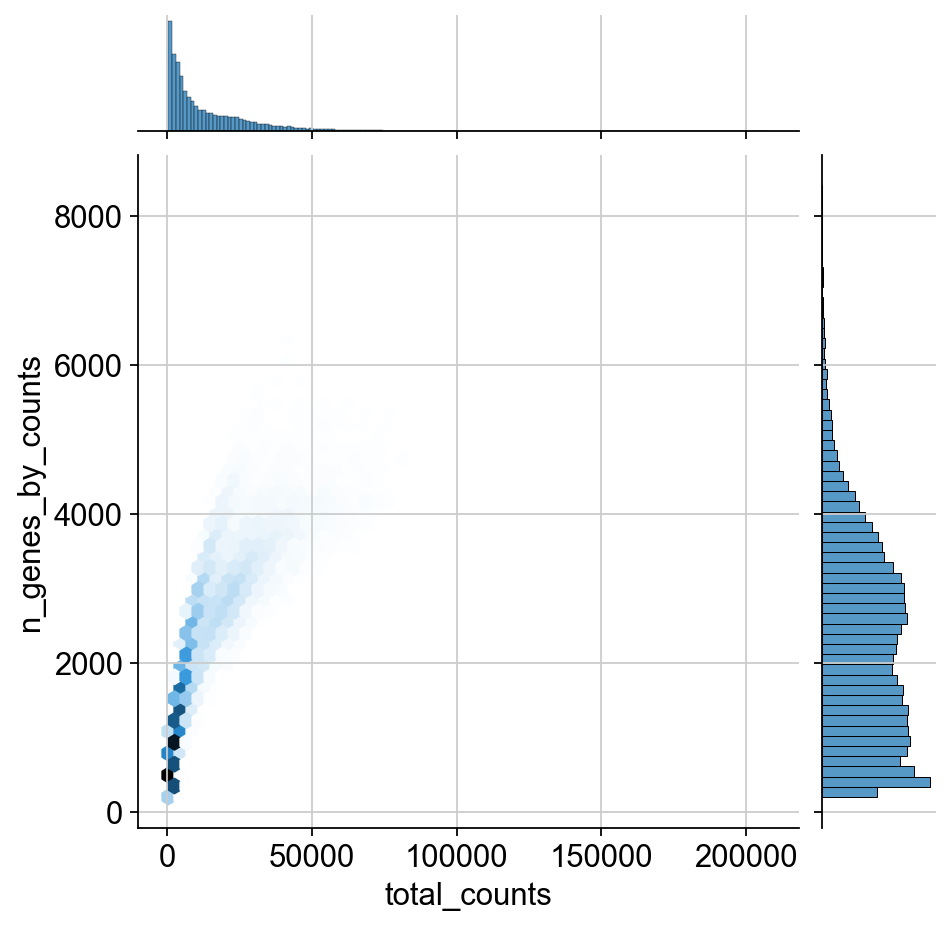

In [6]:
## 6.2 标准化前检查
"""
    - 通过所有基因的总计数对每个细胞进行标准化，
    - 以便标准化后每个细胞具有相同的总计数
    -------------------------------
    - TODO:绘图发现calculate_qc_metrics已经标准化,近似正态
    - TODO:但是之前检查表达矩阵没有改变,inplace已经检查过了
    - TODO:原始数据也还是整数counts
"""

# 发现基本成正态就不管了,数据本身可能是标准化的
# sns.histplot(adata.obs["total_counts"], bins=100, kde=False)
sns.jointplot(adata.obs,x="total_counts",y="n_genes_by_counts",kind="hex")

In [7]:
## 6.3 基本对数标准化
"""Normalization using sc.pp.normalize_total
   - 基于delta方法的移位对数
   - 优于其他揭示数据集潜在结构的方法（特别是在进行主成分分析时）
   - 并且有利于稳定方差，以进行后续的降维和差异表达基因的识别
"""
# scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False) # inplace=True 直接原对象上修改
# # log1p transform
# adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
# # %%
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
# axes[0].set_title("Total counts")
# p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
# axes[1].set_title("Shifted logarithm")
# plt.show()

'Normalization using sc.pp.normalize_total\n   - 基于delta方法的移位对数\n   - 优于其他揭示数据集潜在结构的方法（特别是在进行主成分分析时）\n   - 并且有利于稳定方差，以进行后续的降维和差异表达基因的识别\n'

In [8]:
## 6.4 反卷积标准化：基于池化的尺寸因子估计
"""Normalization using scran
    - 利用反卷积方法根据基于池化的的线性回归来估计大小因子。
    - 旨在更好地解释数据集中所有细胞计数深度的差异
"""
from scipy.sparse import csr_matrix, issparse

# scran 需要粗聚类输入来提高尺寸因子估计性能。
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=15
    finished (0:00:16)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 15


/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-16 22:26:10.669116: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 22:26:10.671062: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 22:26:10.713957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the

    computed neighbors (0:00:20)
    computed connectivities (0:00:03)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
running Leiden clustering
    finished: found 40 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:06)


In [9]:
## 6.4.1 准备表达矩阵和粗聚类分组的数据传递给R
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
"""
    - 检查非零元素的数量是否大于32位整数
    - 对于具有大量非零元素的矩阵,COO格式比CSC格式更节省内存。
"""
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

# input_groups = adata_pp.obs["groups"] 
# # 可以和之前一样直接 %%R -i input_groups -i data_mats

del adata_pp

In [10]:
%%R -o size_factors
library(scran)
library(BiocParallel)

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam(workers = 10) # 10核
    )
)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [11]:
## 6.4.3 整合scran标准化结果到scran_normalization层
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fu

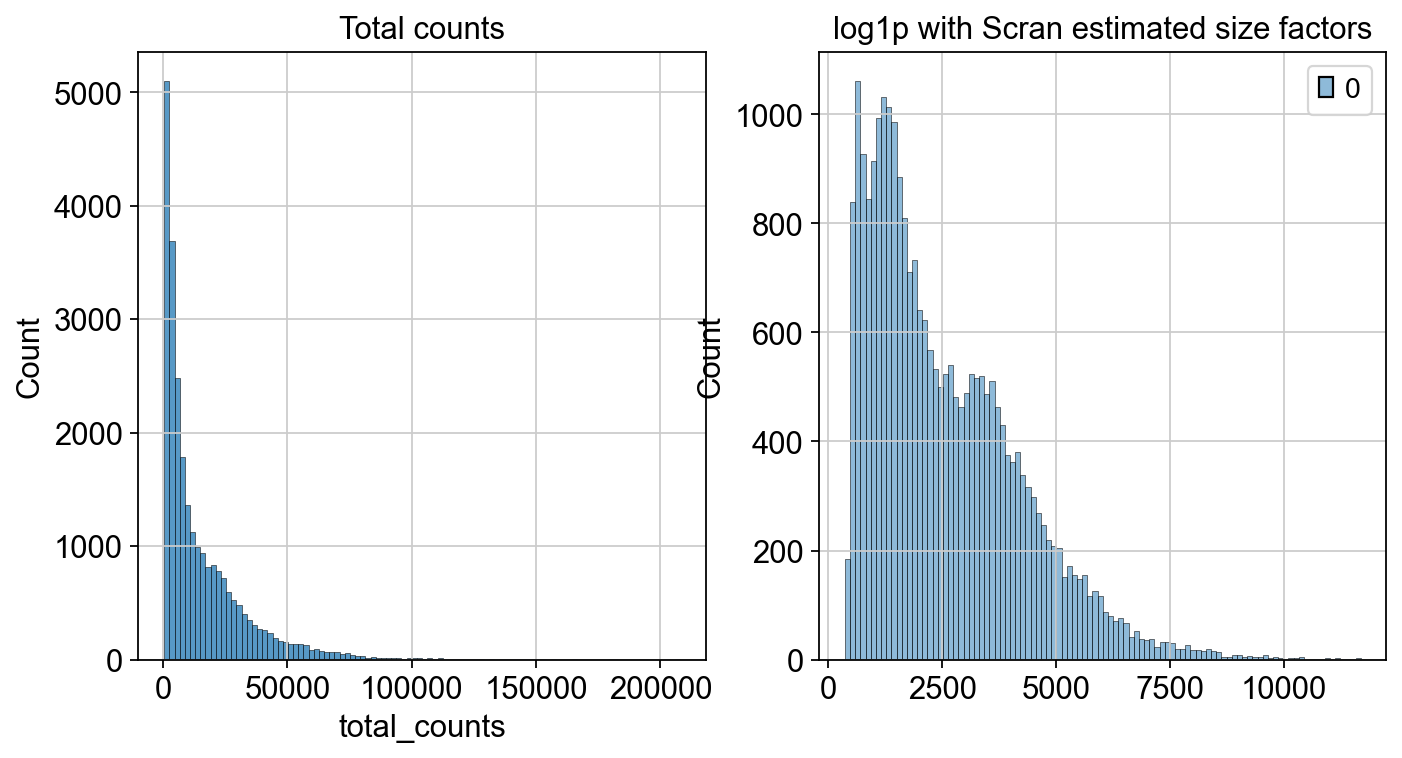

In [12]:
## 6.4.4 绘制scran标准化结果
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
) # sum(1)数据矩阵中每行的总和，即每个细胞的总计数。沿着第二个维度（列）求和
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

In [13]:
## 6.5 正则化负二项式回归：皮尔逊残差标准化
"""Normalization using pearson residuals
    - “正则化负二项式回归”的皮尔逊残差来计算数据中的技术噪声模型。
    - 明确地将计数深度添加为广义线性模型中的协变量
    - 消除了采样效应的影响，同时保留了数据集中的细胞异质性。
    - 分析皮尔逊残差不需要下游启发式步骤，例如伪计数加法或对数转换。
    - 此方法的输出是标准化值，可以是正值，也可以是负值。
"""
# analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
# adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

'Normalization using pearson residuals\n    - “正则化负二项式回归”的皮尔逊残差来计算数据中的技术噪声模型。\n    - 明确地将计数深度添加为广义线性模型中的协变量\n    - 消除了采样效应的影响，同时保留了数据集中的细胞异质性。\n    - 分析皮尔逊残差不需要下游启发式步骤，例如伪计数加法或对数转换。\n    - 此方法的输出是标准化值，可以是正值，也可以是负值。\n'

In [14]:
## 6.5.1 绘制皮尔逊残差标准化结果
# fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
# axes[0].set_title("Total counts")
# p2 = sns.histplot(
#     adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
# )
# axes[1].set_title("Analytic Pearson residuals")
# plt.show()

In [15]:
## 6.6 保存
adata.write("anndata_normalization.h5ad", compression="gzip") # type: ignore